In [19]:
# !pip install --upgrade networkx
# !pip install --upgrade matplotlib

# Informed search on graphs

Some materials were taken from the slides of Bobby! 
**Thank you Bobby!** 🙇

- **Uninformed search** use only the connections and the weights of the edges.
    - DFS, BFS, UCS, DLS, IDS
- **Informed search** strategies use some sort of heuristic to estimate the closeness of each node.
    - Greedy Best-First Search, A*, Beam Search, Hill Climbing
    - “Informed strategies have information on the goal
        state which helps in more efficient searching. This
        information is obtained by a function (heuristic) that
        estimates how close a state is to the goal state.”
        
    - **Heuristic** - example: euclidean distance

## Utilities

In [20]:
from dataclasses import dataclass
from typing import Any
from collections import defaultdict


@dataclass
class Node:
    value: Any = "no"
    heuristic: float = 0
    color: str = "black"


@dataclass
class Graph:
    nodes: Any
    edges: Any
    undirected_edges: Any

    def children_of(self, node_value):
        return [(self.nodes[v], w) for v, w in self.undirected_edges[node_value]]


def make_graph(nodes, edges):
    nodes = {v: Node(value=v, heuristic=h) for v, h in nodes}

    undirected_edges = defaultdict(list)
    for node, children in edges.items():
        for child, weight in children:
            undirected_edges[node].append((child, weight))
            undirected_edges[child].append((node, weight))

    return Graph(nodes=nodes, edges=edges, undirected_edges=undirected_edges)

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import time


def draw_spring_graph(graph, seed=1, figsize=(8, 8)):
    nodes = graph.nodes.values()
    edges = []
    for node, children in graph.edges.items():
        for c, weight in children:
            edges.append((node, c, weight))

    G = nx.Graph()
    for n in nodes:
        G.add_node(n.value)

    for f, t, _ in edges:
        G.add_edge(f, t)

    pos = nx.spring_layout(G, seed=seed)

    plt.figure(figsize=figsize)

    nx.draw_networkx_edges(G, pos, alpha=1, width=3)
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=[n.value for n in nodes],
        node_size=1200,
        node_color=[n.color for n in nodes],
    )
    nx.draw_networkx_labels(
        G,
        pos,
        labels={n.value: f"{n.value}({n.heuristic})" for n in nodes},
        font_size=12,
        font_color="white",
        font_weight="bold",
    )

    edge_labels = dict([((n1, n2), f"{w}") for n1, n2, w in edges])
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, label_pos=0.5, font_size=12
    )

    # Set margins for the axes so that nodes aren't clipped

    ax = plt.gca()
    ax.margins(0.1)
    plt.axis("off")
    plt.show()


def display_graph(g, current, end, front, visited):
    front_set = {v for w, v in front}
    for _, node in g.nodes.items():
        node.color = "black"
        if node.value in front_set:
            node.color = "red"
        if node.value in visited:
            node.color = "blue"
        if node.value == current:
            node.color = "orange"
        if node.value == end:
            node.color = "green"

    draw_spring_graph(g, seed=100, figsize=(14, 8))

# Examples

In [22]:
g = make_graph(
    nodes=[
        ("Z", 11),
        ("S", 8),
        ("A", 7),
        ("B", 5),
        ("C", 4),
        ("D", 6),
        ("E", 6),
        ("F", 3),
        ("G", 0),
        ("H", 9),
        ("I", 8),
        ("J", 7),
        ("K", 8),
    ],
    edges={
        "Z": [("S", 3)],
        "S": [("A", 2), ("B", 3)],
        "A": [("C", 4)],
        "B": [("D", 2)],
        "C": [("G", 4)],
        "D": [("E", 2), ("H", 3), ("I", 3)],
        "E": [("J", 2), ("F", 3)],
        "F": [("G", 3)],
        "J": [("K", 2)],
    },
)

In [23]:
g.nodes["S"].color = "orange"
g.nodes["G"].color = "green"

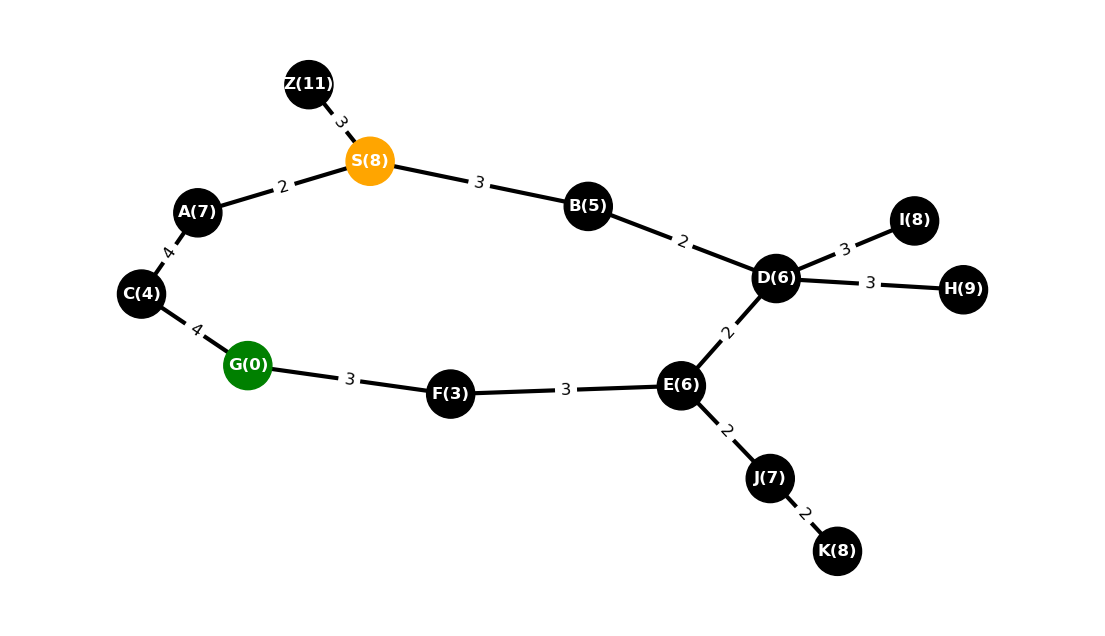

In [24]:
draw_spring_graph(g, seed=100, figsize=(14, 8))

## Best-First - use only the heuristic to chose the next current
- Implementation - priority queue
- **h(n)** = estimate of cost from n to the closest goal

In [25]:
import heapq
from IPython.display import clear_output


def greedy(g, start, end):
    start_node = g.nodes[start]
    queue = [(start_node.heuristic, start)]
    visited = set()

    while len(queue) > 0:
        _, current = heapq.heappop(queue)

        if current == end:
            print("done")
            return

        if current in visited:
            continue
        visited.add(current)

        for child, weight in g.children_of(current):
            if child.value in visited:
                continue
            heapq.heappush(queue, (child.heuristic, child.value))

        # clear_output()
        print(current, visited, queue)
        display_graph(g, current, end, queue, visited)
        # time.sleep(3)

S {'S'} [(5, 'B'), (11, 'Z'), (7, 'A')]


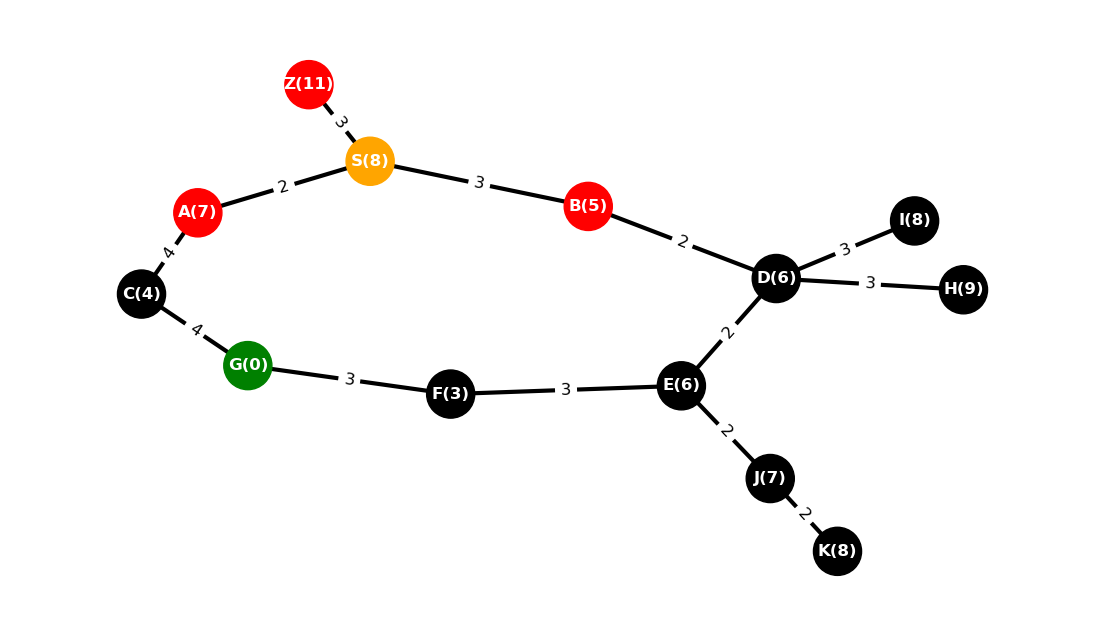

B {'S', 'B'} [(6, 'D'), (11, 'Z'), (7, 'A')]


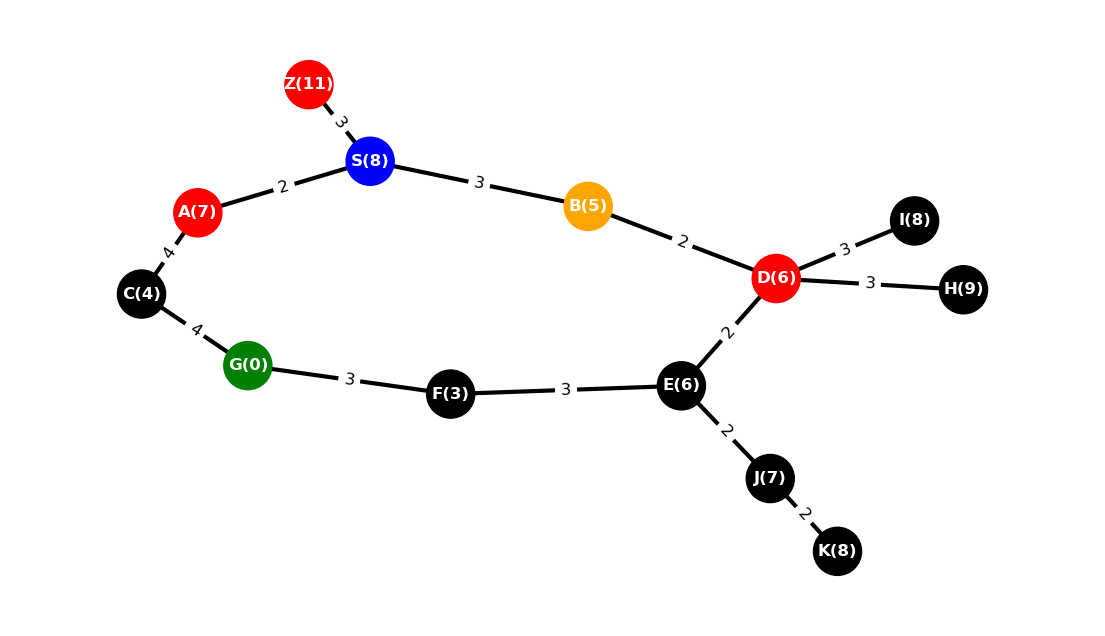

D {'D', 'S', 'B'} [(6, 'E'), (8, 'I'), (7, 'A'), (11, 'Z'), (9, 'H')]


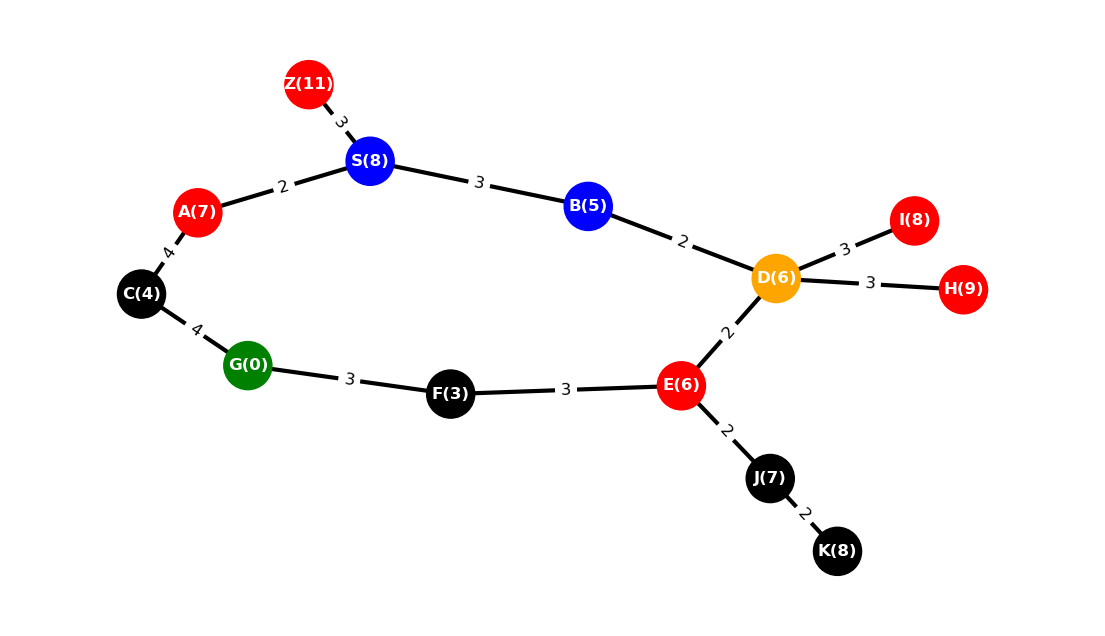

E {'E', 'D', 'S', 'B'} [(3, 'F'), (7, 'J'), (7, 'A'), (11, 'Z'), (8, 'I'), (9, 'H')]


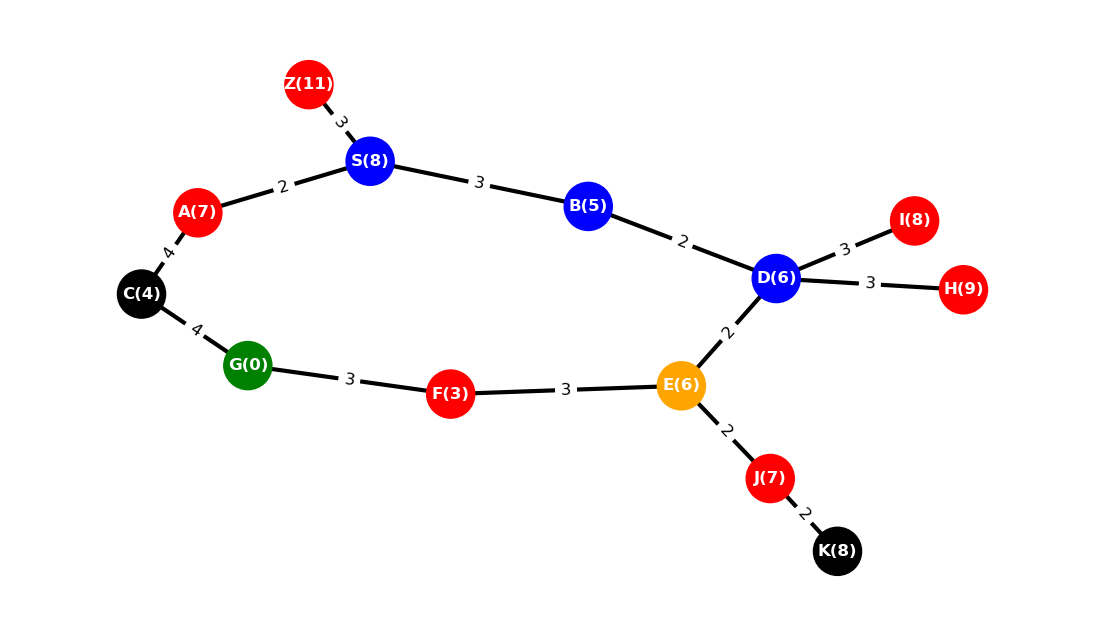

F {'E', 'F', 'D', 'S', 'B'} [(0, 'G'), (7, 'J'), (7, 'A'), (11, 'Z'), (8, 'I'), (9, 'H')]


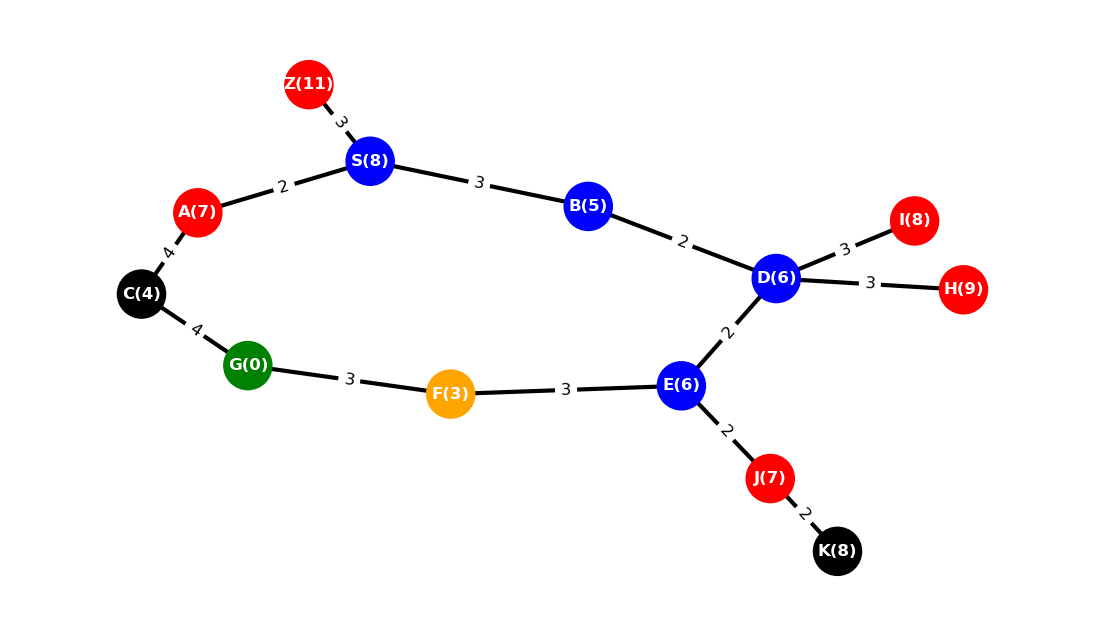

done


In [27]:
greedy(g, "S", "G")

### Analysis
- Complete - No, can get stuck in loops, e.g.,
  
  Iasi → Neamt → Iasi → Neamt →
  
  Complete in finite space with repeated-state checking
  
 - Optimal - No (as we saw)
 - Time - **_O(b<sup>m</sup>)_**, but a good heuristic can give dramatic improvement
 - Space - **_O(b<sup>m</sup>)_**, keeps all nodes in memory

## Beam Search
= greedy best-first search with queue limit l,
i.e., keeps l nodes in the queue

In [28]:
def argmax(arr):
    return max(enumerate(arr), key=lambda x: x[1])[0]


def heap_pop_max(queue):
    # this is a hack that implements linear removal of the max element
    # it is not optimal
    id_max = argmax(queue)
    max_element = queue[id_max]
    new_queue = queue[:id_max] + queue[id_max + 1 :]
    heapq.heapify(new_queue)
    return max_element, new_queue

In [29]:
def beam(g, start, end, beam_size):
    start_node = g.nodes[start]
    queue = [(start_node.heuristic, start)]
    visited = set()

    while len(queue) > 0:
        _, current = heapq.heappop(queue)

        if current == end:
            print("done")
            return

        if current in visited:
            continue
        visited.add(current)

        for child, weight in g.children_of(current):
            if child.value in visited:
                continue

            heapq.heappush(queue, (child.heuristic, child.value))

            # The only addition
            if len(queue) > beam_size:
                _, queue = heap_pop_max(queue)  # Currently O(N), bit it can be O(logN)

        # clear_output()
        print(current, visited, queue)
        display_graph(g, current, end, queue, visited)
        # time.sleep(3)

S {'S'} [(5, 'B'), (7, 'A')]


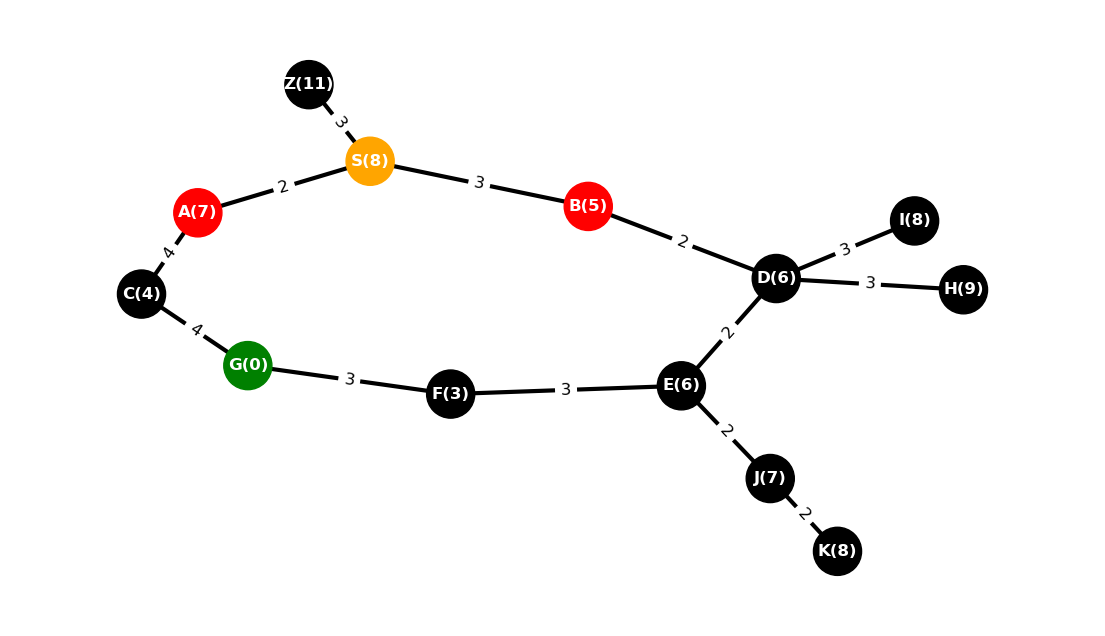

B {'S', 'B'} [(6, 'D'), (7, 'A')]


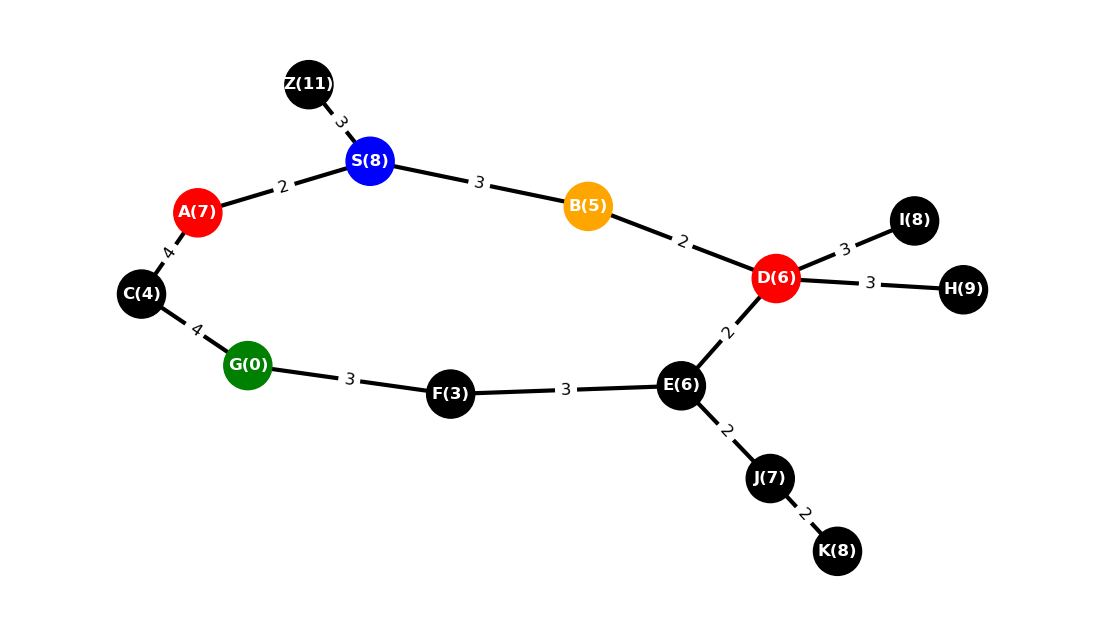

D {'D', 'S', 'B'} [(6, 'E'), (7, 'A')]


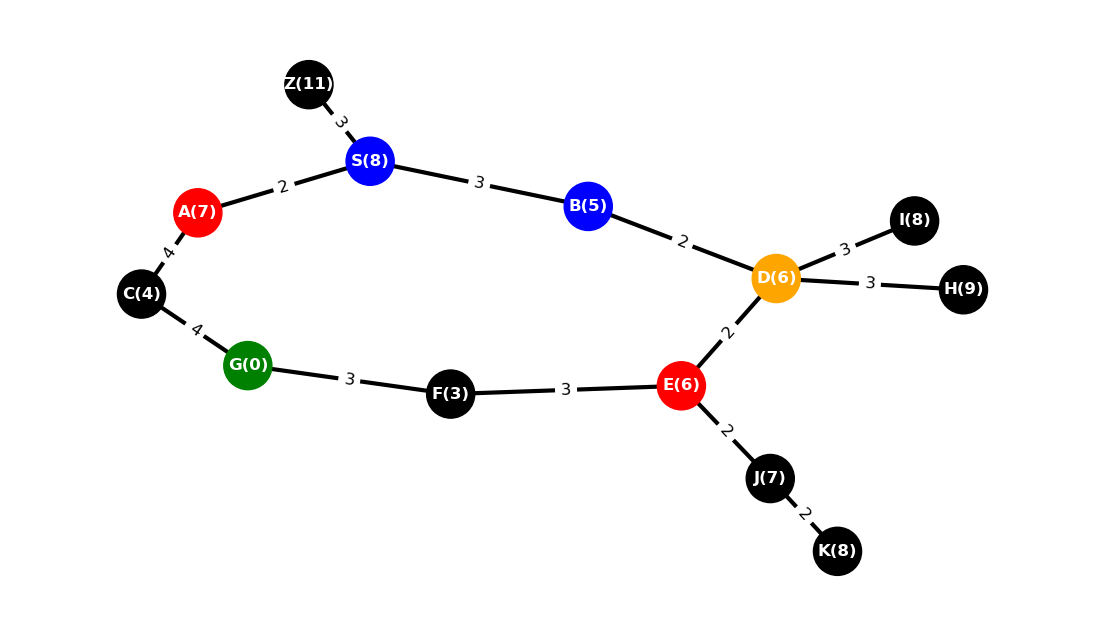

E {'E', 'D', 'S', 'B'} [(3, 'F'), (7, 'A')]


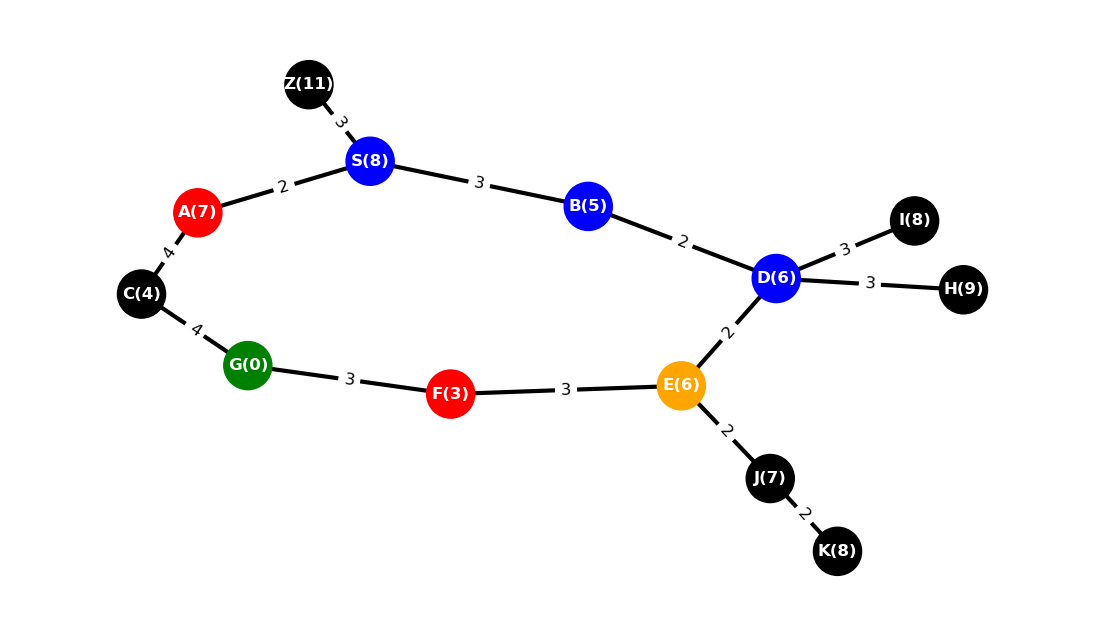

F {'E', 'F', 'D', 'S', 'B'} [(0, 'G'), (7, 'A')]


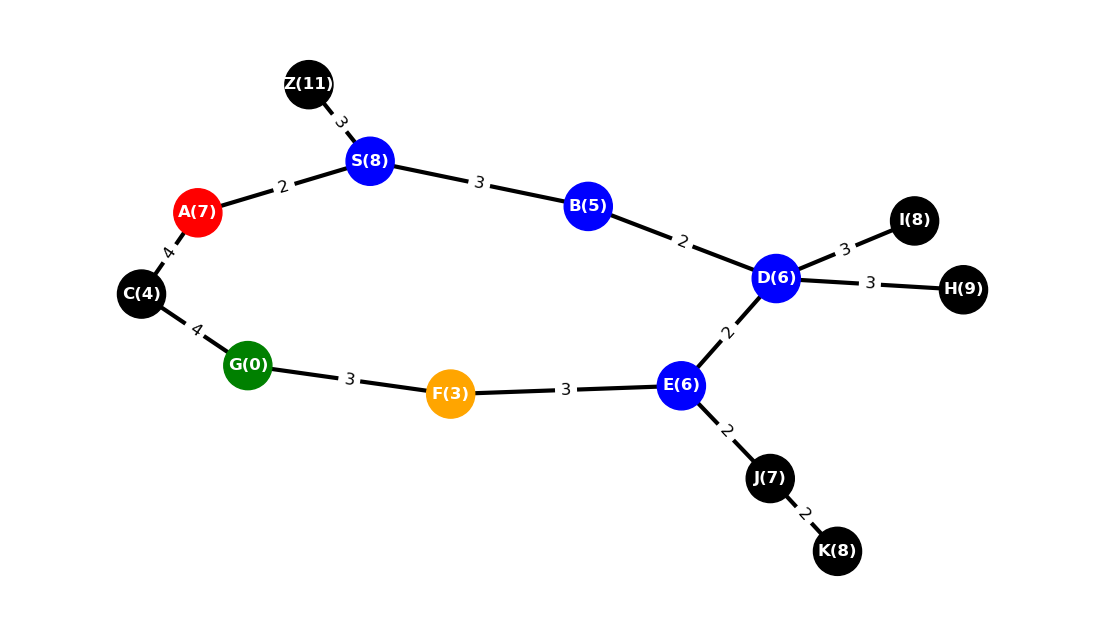

done


In [30]:
beam(g, "S", "G", beam_size=2)
# beam(g, 'S', 'K', beam_size=2) # The algorithm does not find the goal

Beam search is often used in tasks like neural machine translation for generating a better translation from a neural network or other probabilistic model.

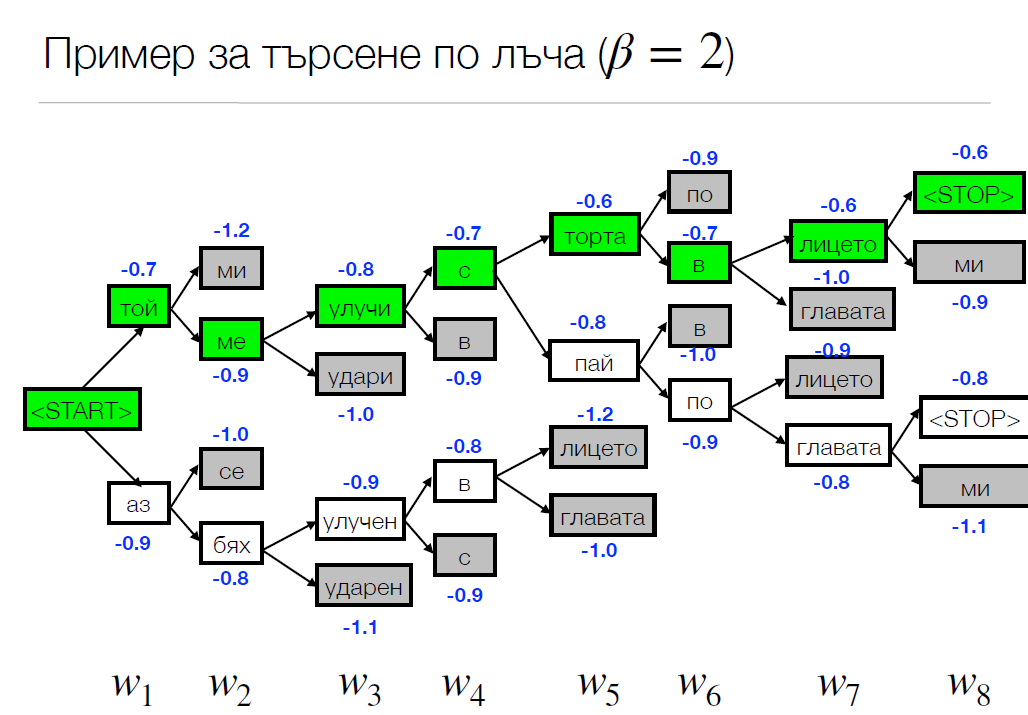

### Analysis
 - Complete - local search
 - Optimal - No (as we saw)
 - Time - **O(blm)**, but a good heuristic can give dramatic improvement
 - Space - **O(bl)**, keeps all nodes in memory

## Hill Climbing

= greedy best-first search with queue limit l = 1,
i.e., keeps only the best node

In [31]:
def hill_climbing(g, start, end):
    beam(g, start, end, 1)

S {'S'} [(5, 'B')]


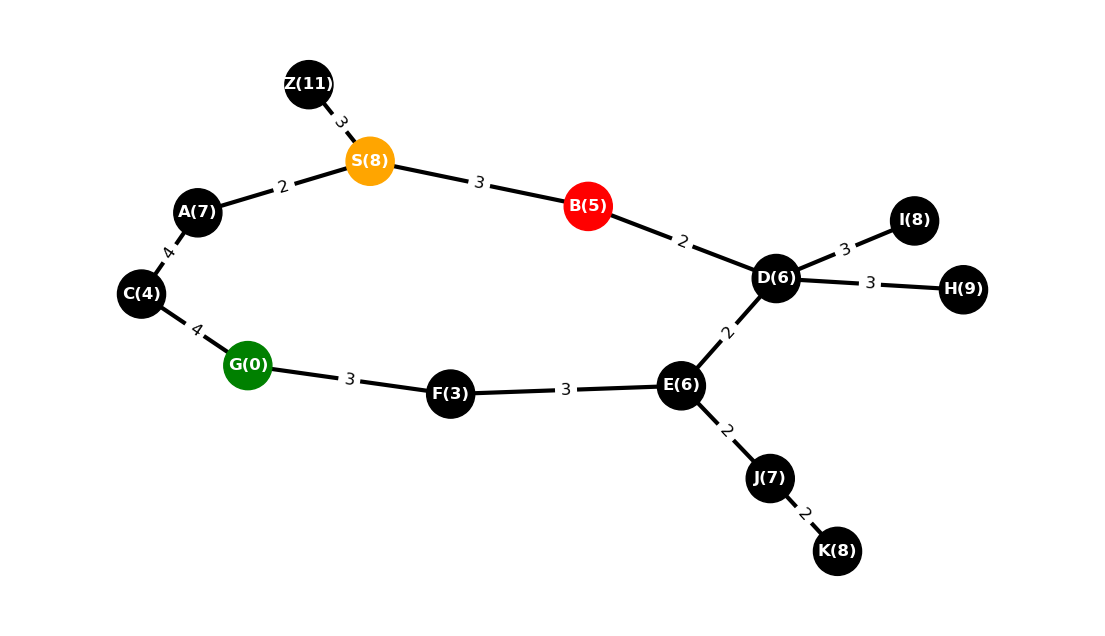

B {'S', 'B'} [(6, 'D')]


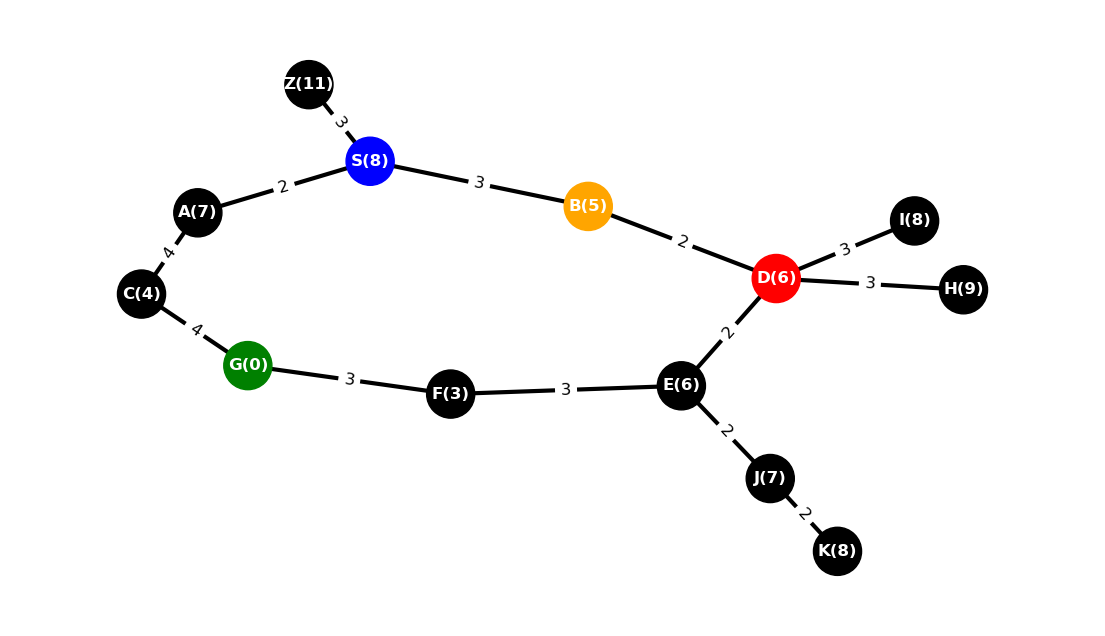

D {'D', 'S', 'B'} [(6, 'E')]


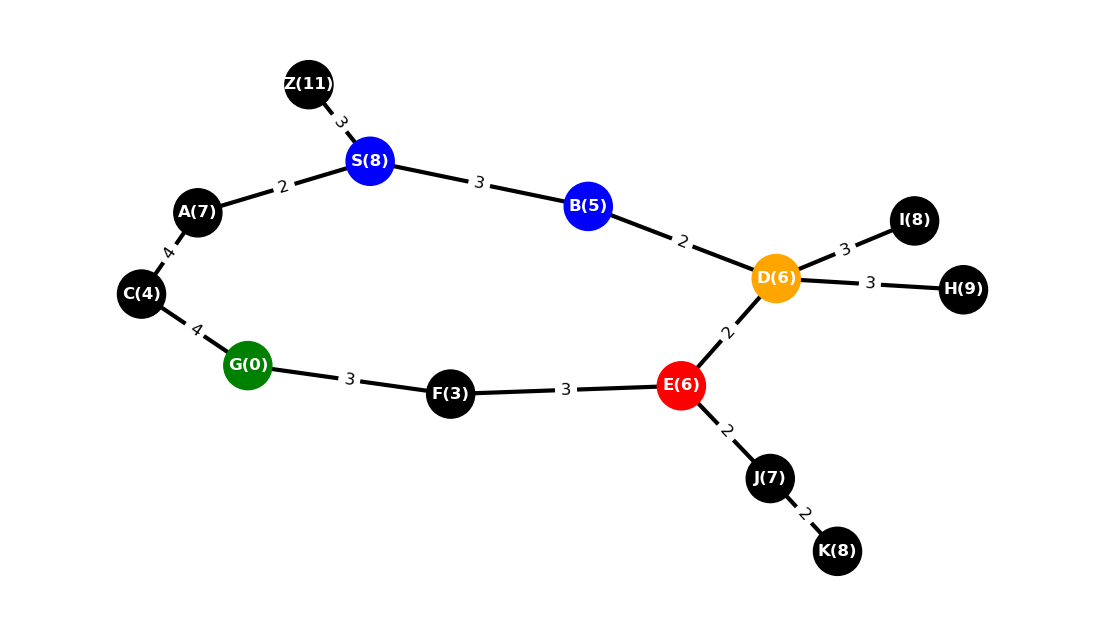

E {'E', 'D', 'S', 'B'} [(3, 'F')]


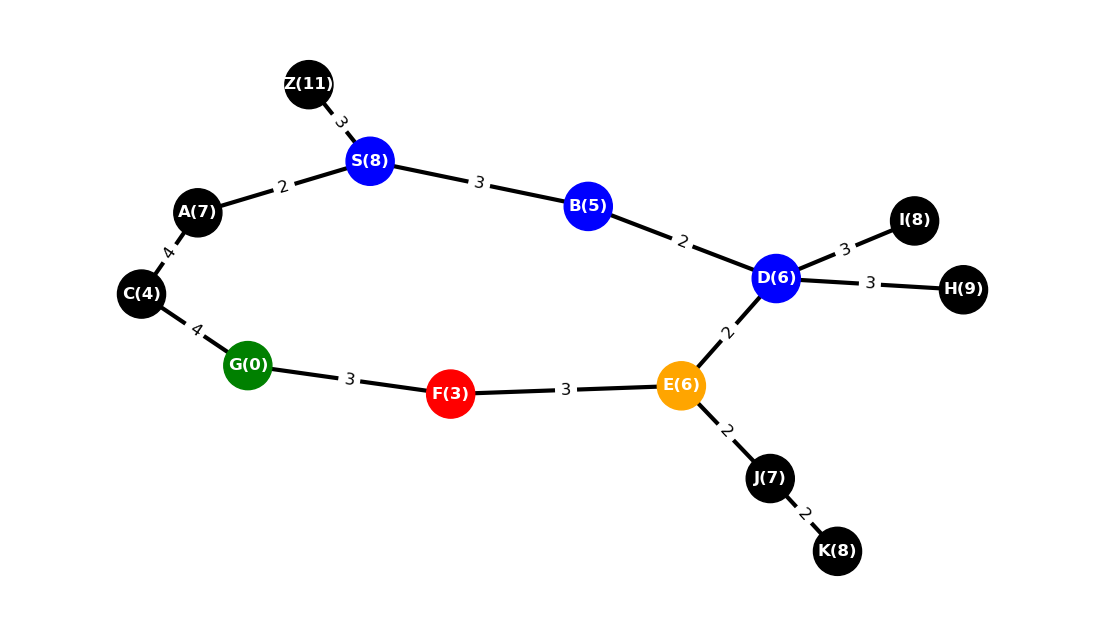

F {'E', 'F', 'D', 'S', 'B'} [(0, 'G')]


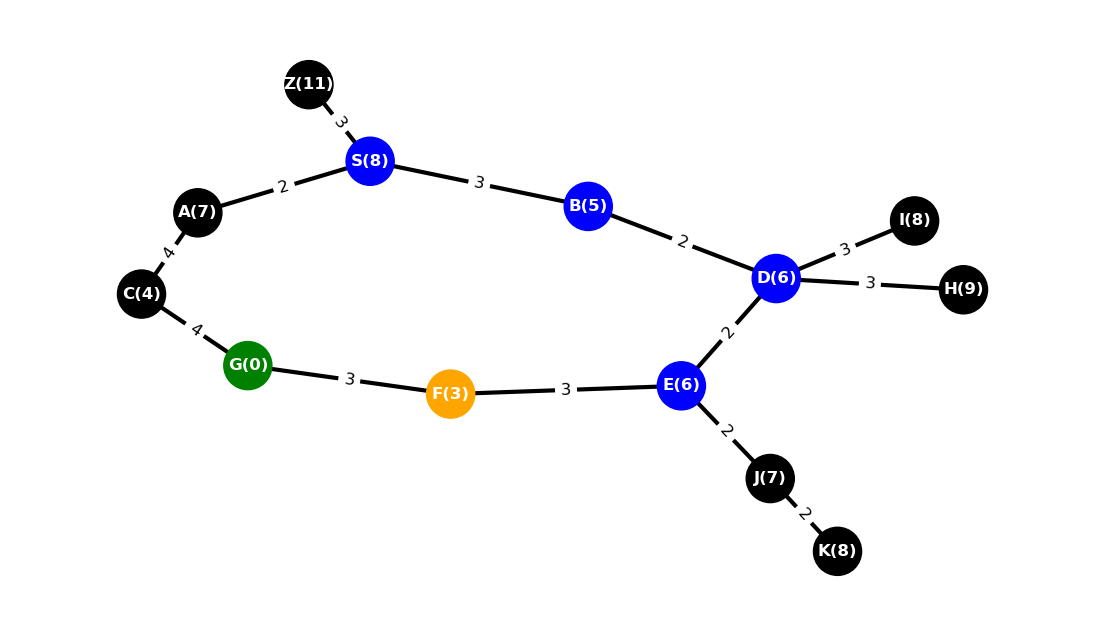

done


In [37]:
hill_climbing(g, "S", "G")

### Analysis
 - Complete - local search
 - Optimal - No (as we saw)
 - Time - **O(bm)**, but a good heuristic can give dramatic improvement
 - Space - **O(b)**, keeps all nodes in memory

## A*

- Avoid expanding paths that are already expensive
- Evaluation function **f(n) = g(n) + h(n)**
  - g(n) = cost so far to reach n
  - h(n) = estimated cost to goal from n
  - f(n) = estimated total cost of path through n to goal
- A* search uses an admissible heuristic
    i.e., h(n) ≤ h*(n) where h*(n) is the true cost from n.
    (Also require h(n) ≥ 0, so h(G) = 0 for any goal G.)

![image.png](https://miro.medium.com/max/368/1*HppvOLfDxXqQRFn0Cv2dHQ.gif)

In [33]:
def relax_element(queue, element):
    new_key, value = element
    new_queue = [(key, v) for key, v in queue if v != value]
    new_queue.append((new_key, value))
    heapq.heapify(new_queue)
    return new_queue

In [34]:
# queue = [(2, 'A'), (1, 'B')]
# heapq.heapify(queue)
# print(queue)
# queue = relax_element(queue, (0, 'A'))
# queue

In [35]:
def A_star(g, start, end):
    start_node = g.nodes[start]
    queue = [(start_node.heuristic, start)]
    visited = set()
    distances = {start: 0}

    while len(queue) > 0:
        _, current = heapq.heappop(queue)

        if current == end:
            print("done!")
            return

        if current in visited:
            continue
        visited.add(current)

        for child_node, weight in g.children_of(current):
            if child_node.value in visited:
                continue

            distance_to_child = distances[current] + weight

            if child_node.value in distances:
                best_distance = min(distances[child_node.value], distance_to_child)
                distances[child_node.value] = best_distance
            else:
                distances[child_node.value] = distance_to_child

            f = child_node.heuristic + @
            heapq.heappush(queue, (f, child_node.value))

        # clear_output()
        print(current, visited, queue)
        display_graph(g, current, end, queue, visited)
        # time.sleep(3)

S {'S'} [(8, 'B'), (14, 'Z'), (9, 'A')]


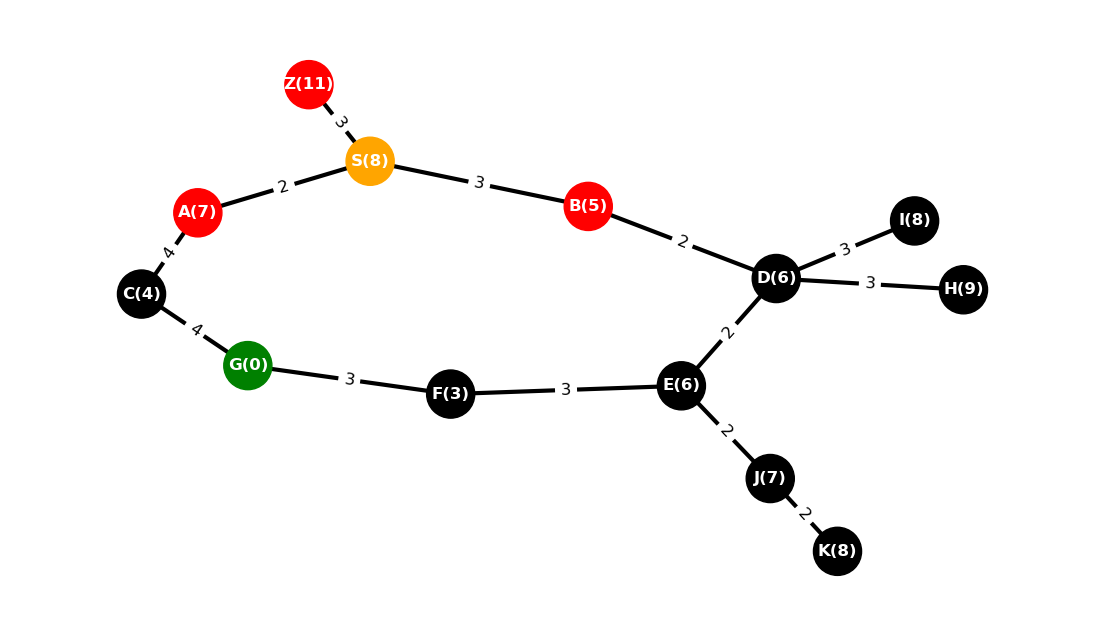

B {'S', 'B'} [(9, 'A'), (14, 'Z'), (11, 'D')]


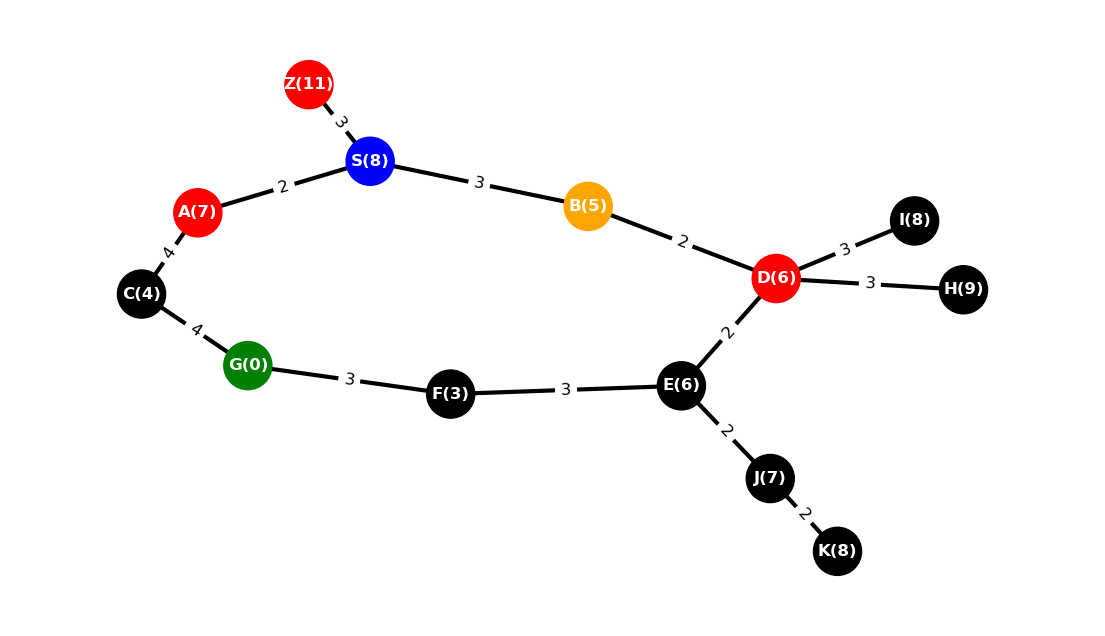

A {'A', 'S', 'B'} [(10, 'C'), (14, 'Z'), (11, 'D')]


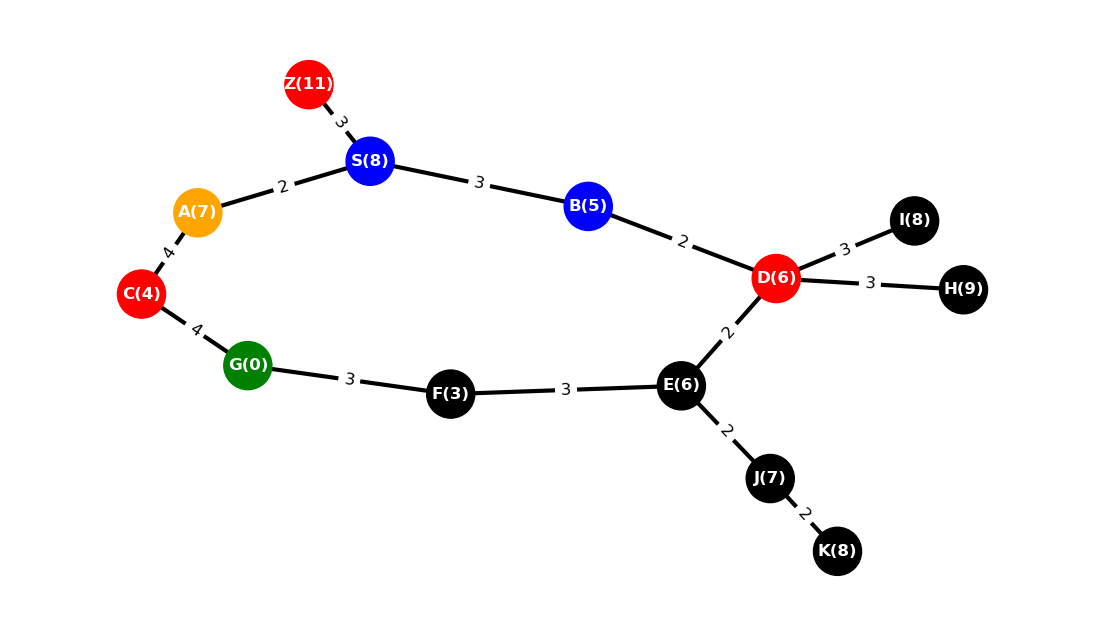

C {'A', 'S', 'C', 'B'} [(10, 'G'), (14, 'Z'), (11, 'D')]


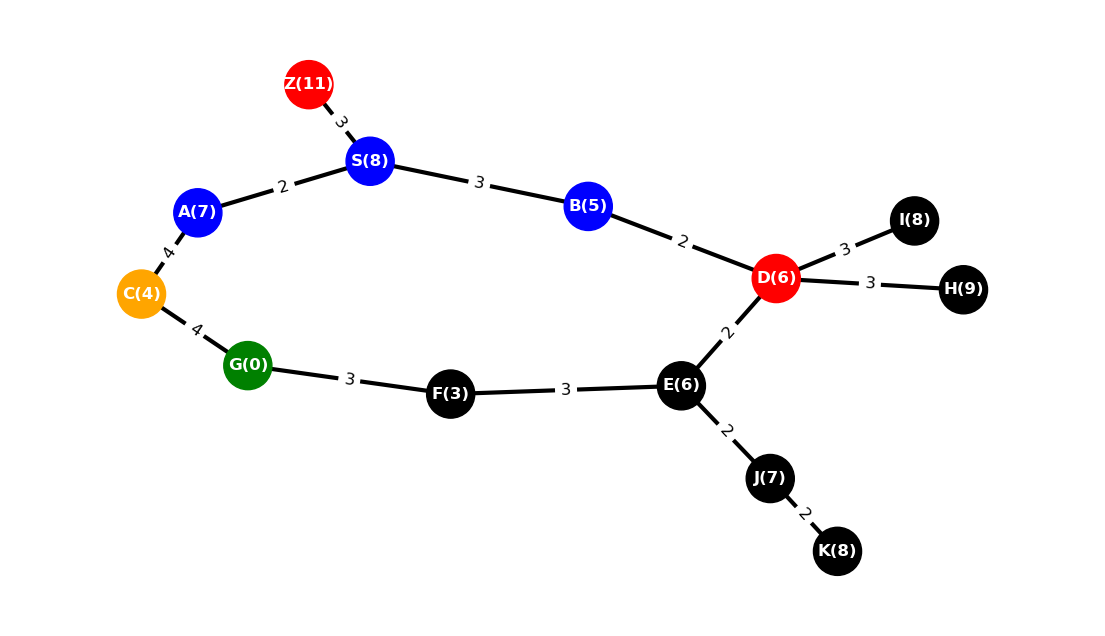

done!


In [36]:
A_star(g, "S", "G")

### Analysis
 - Complete, unless there are infinitely many nodes with f ≤ f(G)
 - Optimal - Yes, cannot expand fi+1 until fi is finished
 - Time - **_O(b<sup>d</sup>)_**: Exponential in [relative error in h × length of soln.]
 - **_O(b<sup>d</sup>)_**: Keeps all nodes in memory

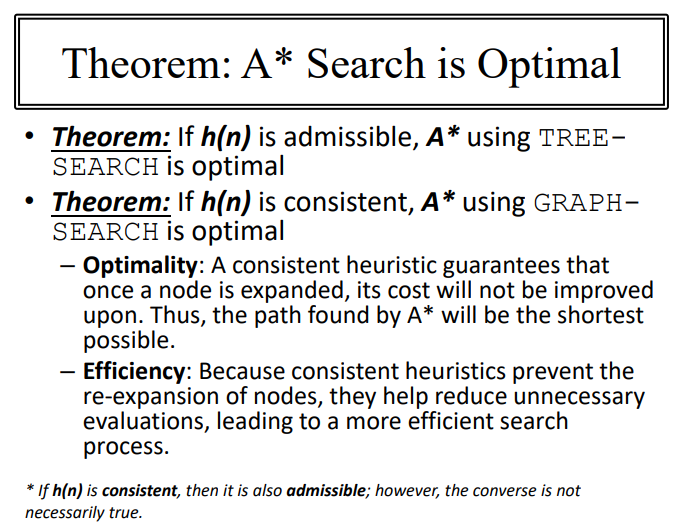

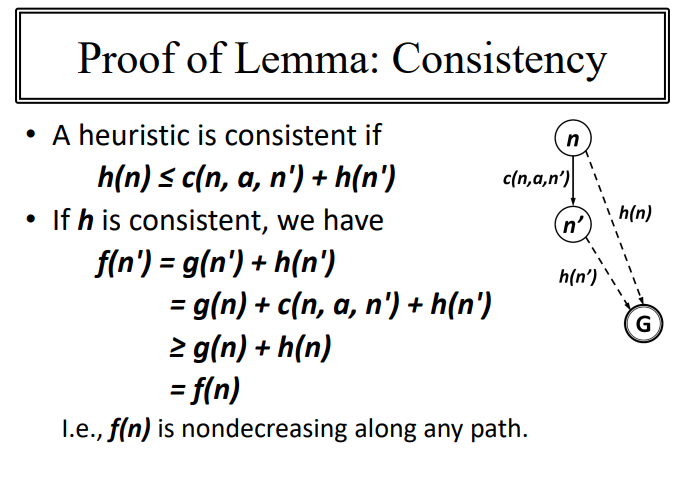

## Memory-Based A*

= combination between A* and beam-search,
i.e., keeps l nodes in the queue

## Iterative Deepening A*

= combination between A* and iterativedeepening-search

[Iterative Deepening A*](https://en.wikipedia.org/wiki/Iterative_deepening_A*)

[Interactive Iterative Deepening A*](https://algorithmsinsight.files.wordpress.com/2016/03/ida-star.gif?w=1326)

## Summary

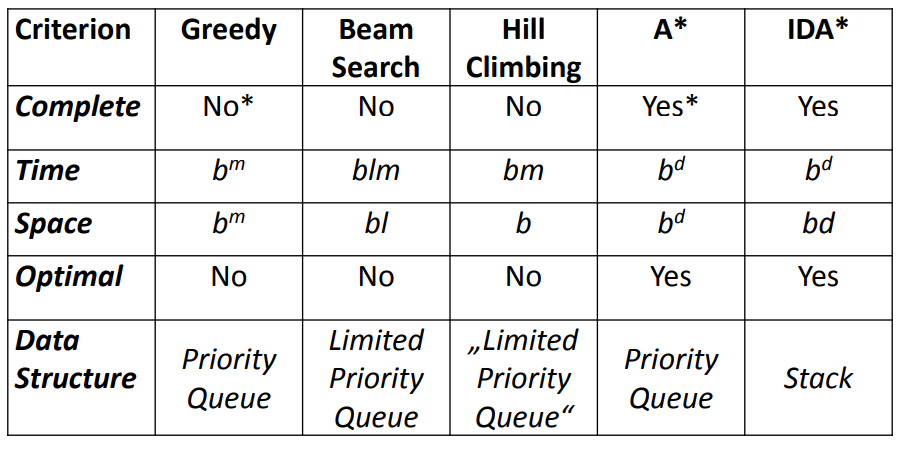

# Homework: “Sliding Blocks (N Puzzle)”

- [The game](https://mypuzzle.org/sliding) starts with a board consisting of blocks numbered 1 through N
    and one blank block represented by the number 0. The goal is to arrange
    the tiles according to their numbers. Moving is done by moving the blocks
    on top, bottom, left and right in place of the empty block.
- At the input is given the number N - the number of blocks with numbers
    (8, 15, 24, etc.), the number I - the index of the position of zero (the empty
    block) in the decision (using -1 the default zero index position is set at the
    bottom right) and then the layout of the board is introduced. Using the A*
    (or IDA*) algorithm and the Manhattan distance heuristics (or Hemming
    distance), derive:
- In the first line, the length of the "optimal" path from start to destination.
- The appropriate steps (in a new line for each one) that are taken to reach
    the final state. The steps are left, right, up and down
- Keep in mind that not every puzzle is solvable. You can [check whether the
    puzzle is solvable](https://www.cs.princeton.edu/courses/archive/spring18/cos226/assignments/8puzzle/index.html) or directly use valid examples.

- Sample input:
    ```
    8
    -1
    1 2 3
    4 5 6
    0 7 8
    ```
- Sample output:
    ```
    2
    left
    left
    ```

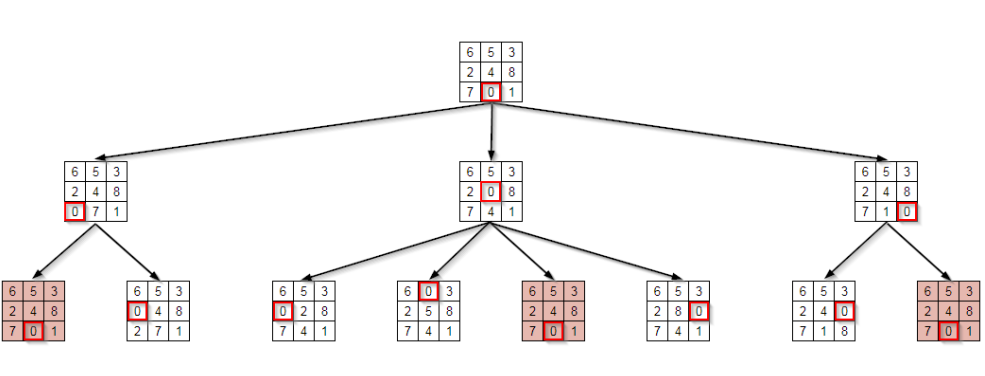

## Local Search

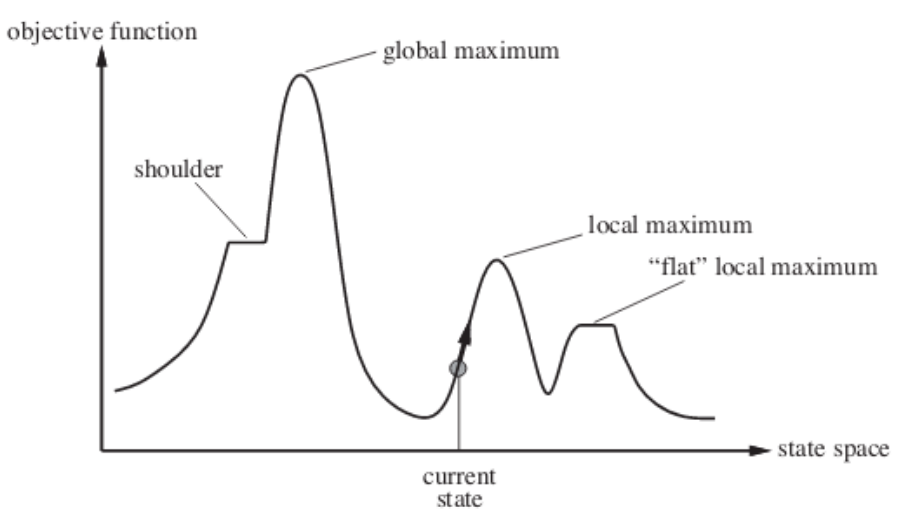

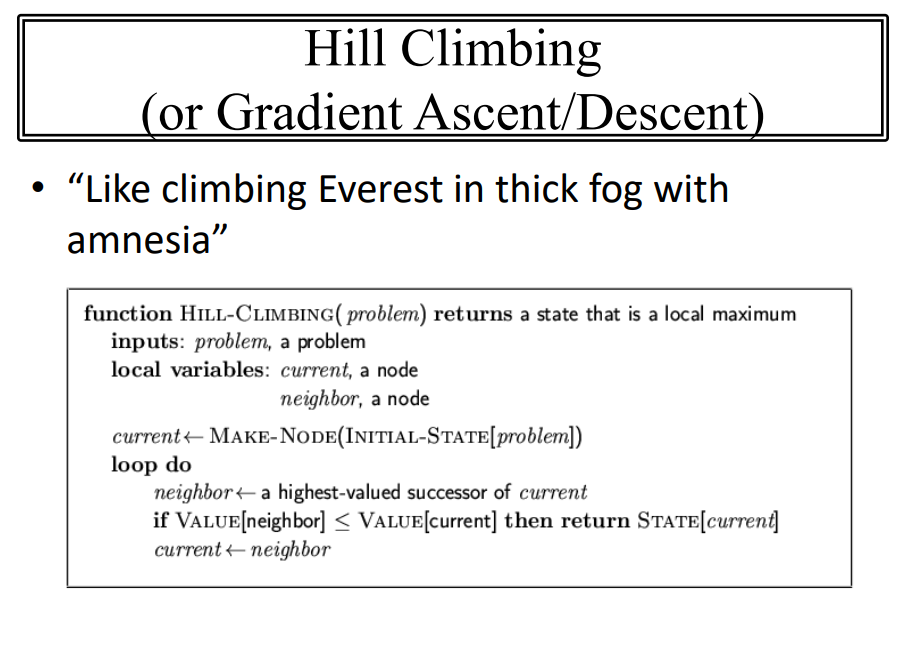

## Hill Climbing with Simulated Annealing

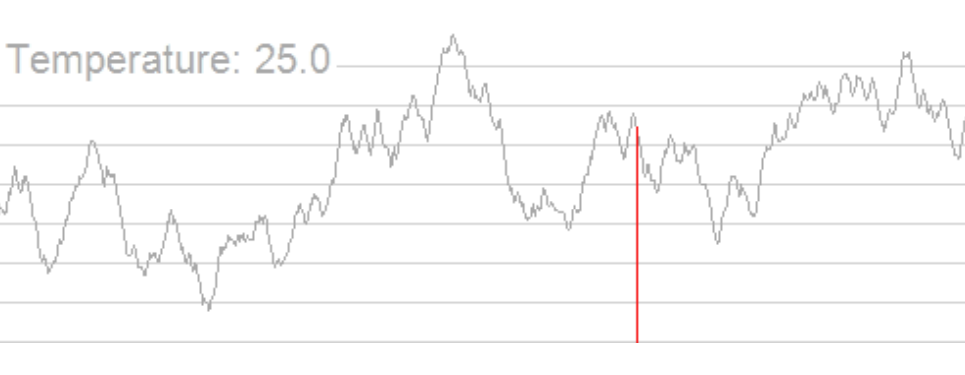

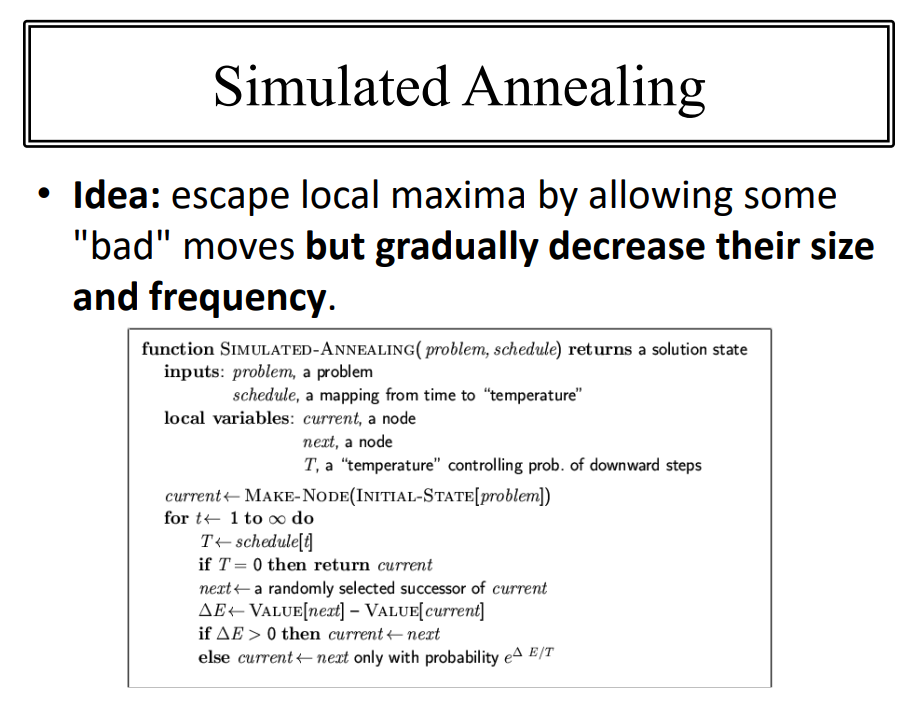